In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# 1. Load data
df = pd.read_csv("Combined Data.csv")
df = df.dropna(subset=['statement'])

# 2. Batasi data untuk testing (misalnya 3000 kalimat dulu)
df = df.sample(n=3000, random_state=42)  # ubah n sesuai RAM kamu

# 3. TF-IDF hemat memori
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')  # batasi fitur!
X = vectorizer.fit_transform(df['statement'])

# 4. Clustering KMeans
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X)

# 5. Tambahkan ke dataframe
df['cluster'] = clusters

# 6. Tampilkan ringkasan
for i in range(k):
    print(f"\n--- Cluster {i} ---")
    print(df[df['cluster'] == i]['statement'].head(5))



--- Cluster 0 ---
3008                  I'm lazy to complain about it ba ihh
44705    i think the wifi on my iphone is broken it wil...
32298                    that's your favorite thing to do?
14408    I have enough goodies to play santa claus but ...
2536     want to sleep but soon the call to prayer for ...
Name: statement, dtype: object

--- Cluster 1 ---
50186    Good tracking apps? I've been trying to find a...
48989    Is it good to only focus on 1 goal? What I mea...
18708    Hi guys, I am looking for podcasts to listen t...
18853    I had such positive momentum going for weeks. ...
14234    I did not realise it was becoming a problem un...
Name: statement, dtype: object

--- Cluster 2 ---
13755    I have recently looked into reddit and found t...
51249    How do I know if I should actually be upset ab...
10862    Last year, during the UK lockdown, was the ver...
19127    I think I am depressed. I decided to type out ...
23765    No matter what I do I only feel like I can sor

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



--- Cluster 0 ---
3008                  I'm lazy to complain about it ba ihh
50186    Good tracking apps? I've been trying to find a...
45438    Do you give in or abstain during periods of hy...
50934    I made a friend for the first time since middl...
36825    @CITYPUBLICITY During revamp and shortly after...
Name: statement, dtype: object

--- Cluster 1 ---
44705    i think the wifi on my iphone is broken it wil...
32298                    that's your favorite thing to do?
14408    I have enough goodies to play santa claus but ...
2536     want to sleep but soon the call to prayer for ...
33382    you use them to wipe the handle of the shoppin...
Name: statement, dtype: object

--- Cluster 2 ---
13755    I have recently looked into reddit and found t...
51249    How do I know if I should actually be upset ab...
10862    Last year, during the UK lockdown, was the ver...
10808    Hey I am about to turn 15 in about two weeks a...
19127    I think I am depressed. I decided to type out 

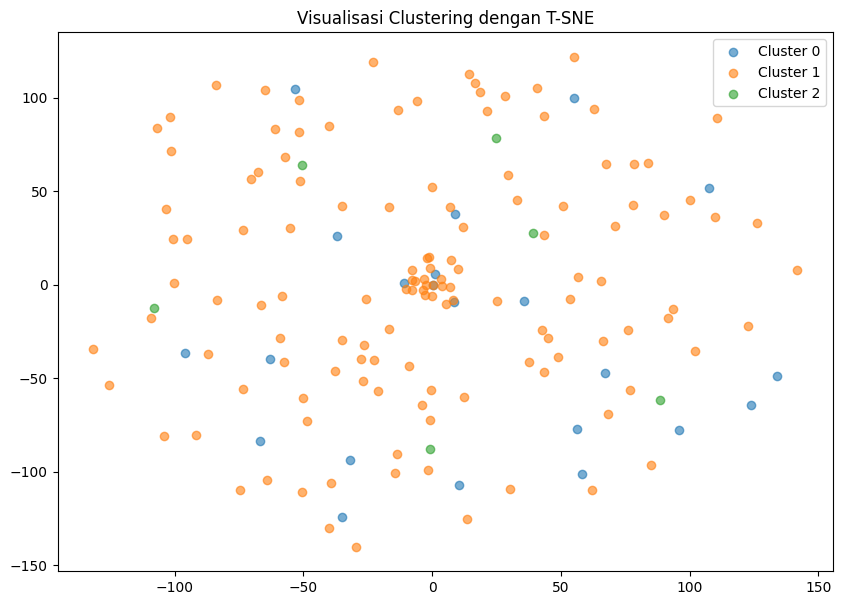

In [7]:
import pandas as pd
import nltk
import re
import string
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Unduh semua resource yang dibutuhkan
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
# Unduh resource punkt_tab yang dibutuhkan oleh word_tokenize
nltk.download('punkt_tab')


# 1. Load data
df = pd.read_csv("Combined Data.csv")
df = df.dropna(subset=['statement'])

# 2. Ambil sample (hemat memori)
df = df.sample(n=3000, random_state=42)

# 3. Preprocessing function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# 4. Terapkan preprocessing
df['clean_text'] = df['statement'].apply(preprocess)

# 5. TF-IDF
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['clean_text'])

# 6. Clustering KMeans
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X)

# 7. Tampilkan contoh kalimat per cluster
for i in range(k):
    print(f"\n--- Cluster {i} ---")
    print(df[df['cluster'] == i]['statement'].head(5))

# 8. Top kata per cluster
def get_top_terms_per_cluster(tfidf_matrix, labels, terms, top_n=10):
    df_result = pd.DataFrame()
    for i in range(k):
        cluster_indices = np.where(labels == i)
        cluster_tfidf = tfidf_matrix[cluster_indices].mean(axis=0)
        cluster_tfidf = np.squeeze(np.asarray(cluster_tfidf))
        top_indices = cluster_tfidf.argsort()[::-1][:top_n]
        top_terms = [terms[ind] for ind in top_indices]
        df_result[f'Cluster {i}'] = top_terms
    return df_result

top_words = get_top_terms_per_cluster(X, df['cluster'].values, vectorizer.get_feature_names_out())
print("\nTop Words per Cluster:")
print(top_words)

# 9. Visualisasi dengan T-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X.toarray())

df_tsne = pd.DataFrame(X_tsne, columns=['x', 'y'])
df_tsne['cluster'] = df['cluster']

plt.figure(figsize=(10, 7))
for i in range(k):
    plt.scatter(df_tsne[df_tsne['cluster'] == i]['x'],
                df_tsne[df_tsne['cluster'] == i]['y'],
                label=f'Cluster {i}', alpha=0.6)
plt.legend()
plt.title("Visualisasi Clustering dengan T-SNE")
plt.show()